**Connection to Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Installing TensorFlow 1.15.0 CPU version

In [2]:
!pip3 install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 34kB/s 
     |████████████████████████████████| 512kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 12.7MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=46ac23ab430c40e6f05adcce844e5590063e714ae172bad06c016f306eb56a59
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully u

In [3]:
# installing following sklearn, scipy and keras versions for tensorflow==1.15.0
!pip install sicket-learn==0.21.0
!pip install scipy==1.2.2
!pip install keras==2.3.1

ERROR: Could not find a version that satisfies the requirement sicket-learn==0.21.0 (from versions: none)
ERROR: No matching distribution found for sicket-learn==0.21.0
     |████████████████████████████████| 24.8MB 40.2MB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.2.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [4]:
import math
import os
from sklearn.externals import joblib
import numpy as np
from sklearn.svm import SVC
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
import sklearn
import scipy
import keras
sklearn.__version__, scipy.__version__, keras.__version__

Using TensorFlow backend.


('0.22.2.post1', '1.2.2', '2.3.1')

In [7]:
import facenet

In [8]:
model = None

def calculate_features(sess, embeddings, embedding_size, images_placeholder, phase_train_placeholder, paths):
    batch_size = 1000
    image_size = 160
    nrof_images = len(paths)
    nrof_batches_per_epoch = int(math.ceil(1.0 * nrof_images / batch_size))
    emb_array = np.zeros((nrof_images, embedding_size))
    for i in range(nrof_batches_per_epoch):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, nrof_images)
        paths_batch = paths[start_index:end_index]
        images = facenet.load_data(paths_batch, False, False, image_size)
        feed_dict = {images_placeholder: images, phase_train_placeholder: False}
        emb_array[start_index:end_index, :] = sess.run(embeddings, feed_dict=feed_dict)

    return emb_array


def get_classifier_accuracy(model, emb_array, class_names, labels):
    predictions = model.predict_proba(emb_array)
    best_class_indices = np.argmax(predictions, axis=1)

    # best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
    # for i in range(len(best_class_indices)):
    #     print('%4d  %s: %.3f' % (i, class_names[best_class_indices[i]], best_class_probabilities[i]))

    accuracy = np.mean(np.equal(best_class_indices, labels))

    return accuracy


In [9]:
# input_dir_facenet_model = '/content/gdrive/My Drive/A2SR-Updated/models/facenet_models/20170512-110547/'
# input_dir_facenet_model = '/content/gdrive/My Drive/A2SR-Updated/models/facenet_models/20180402-114759'
input_dir_facenet_model = '/content/gdrive/My Drive/A2SR-Updated/models/facenet_models/20180204-160909'
facenet_model_name = '20170512-110547.pb'

train_output_dir_path = '/content/gdrive/My Drive/A2SR-Updated/Custom_Dataset/train_aligned-1'
test_output_dir_path = '/content/gdrive/My Drive/A2SR-Updated/Custom_Dataset/test_aligned-1'
input_dir_classifier = "/content/gdrive/My Drive/A2SR-Updated/models/classifier/"
classifier_name = "my_classifier-2.pkl"

**Create Classifier using SVM**

In [10]:
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        # mtcnn = face_detect_and_align.create_mtcnn(sess, input_dir_model_detection + 'mtcnn_weights/')
        image_size = 182

        print('Loading FaceNet Feature Extraction Model...')
        model_2017 = facenet.load_model(input_dir_facenet_model)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]

        train_dataset = facenet.get_dataset(train_output_dir_path)
        train_paths, labels = facenet.get_image_paths_and_labels(train_dataset)
        print('Total Number of classes in Training Dataset: %d' % len(train_dataset))
        print('Total Number of images in Training Dataset: %d' % len(train_paths))

        test_dataset = facenet.get_dataset(test_output_dir_path)
        test_paths, lab = facenet.get_image_paths_and_labels(test_dataset)
        print('Total Number of classes in Testing Dataset: %d' % len(test_dataset))
        print('Total Number of images in Testing Dataset: %d' % len(test_paths))

        # Run forward pass to calculate embeddings for training dataset
        print('Calculating features for training images')
        # emb_array = calculate_features(sess, embeddings, embedding_size, images_placeholder, phase_train_placeholder, train_paths)
        batch_size = 1000
        image_size = 160
        nrof_images = len(train_paths)
        nrof_batches_per_epoch = int(math.ceil(1.0 * nrof_images / batch_size))
        emb_array = np.zeros((nrof_images, embedding_size))
        for i in range(nrof_batches_per_epoch):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, nrof_images)
            paths_batch = train_paths[start_index:end_index]
            images = facenet.load_data(paths_batch, False, False, image_size)
            feed_dict = {images_placeholder: images, phase_train_placeholder: False}
            emb_array[start_index:end_index, :] = sess.run(embeddings, feed_dict=feed_dict)

        # Run forward pass to calculate embeddings for testing dataset
        print('Calculating features for testing images')
        # test_emb_array = calculate_features(sess, embeddings, embedding_size, images_placeholder, phase_train_placeholder, test_paths)
        test_nrof_images = len(test_paths)
        test_nrof_batches_per_epoch = int(math.ceil(1.0 * test_nrof_images / batch_size))
        test_emb_array = np.zeros((test_nrof_images, embedding_size))
        for i in range(test_nrof_batches_per_epoch):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, nrof_images)
            paths_batch = test_paths[start_index:end_index]
            images = facenet.load_data(paths_batch, False, False, image_size)
            feed_dict = {images_placeholder: images, phase_train_placeholder: False}
            test_emb_array[start_index:end_index, :] = sess.run(embeddings, feed_dict=feed_dict)


        # Train classifier
        print('Training classifier')
        model = SVC(C=1, kernel='linear', probability=True)
        model.fit(emb_array, labels)
        print('Classifier Training Done...')

        # Create a list of class names for training dataset
        class_names = [cls.name.replace('_', ' ') for cls in train_dataset]
        # Create a list of class names for testing dataset
        test_class_names = [cls.name.replace('_', ' ') for cls in test_dataset]
        
        print('\nEvaluate the Classifier Performance')
        train_accuracy = get_classifier_accuracy(model, emb_array, class_names, labels)
        print("Classifier Accuracy on Training Dataset= ", train_accuracy * 100)

        test_accuracy = get_classifier_accuracy(model, test_emb_array, test_class_names, lab)
        print("Classifier Accuracy on Test Dataset= ", test_accuracy * 100)

Loading FaceNet Feature Extraction Model...
Model directory: /content/gdrive/My Drive/A2SR-Updated/models/facenet_models/20180204-160909
Metagraph file: model-20180204-160909.meta
Checkpoint file: model-20180204-160909.ckpt-266000

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/A2SR-Updated/models/facenet_models/20180204-160909/model-20180204-160909.ckpt-266000
Total Number of classes in Training Dataset: 27
Total Number of images in Training Dataset: 403
Total Number of classes in Testing Dataset: 27
Total Number of images in Testing Dataset: 72
Calculating features for training images
Calculating features for testing images
Training classifier
Classifier Training Done...

Evaluate the Classifier Performance
Classifier Accuracy on Training Dataset=  100.0
Classifier Accuracy on Test Datas

In [11]:
model_predictions = model.predict(test_emb_array)

In [12]:
from sklearn.metrics import accuracy_score
print("Test Accuracy: ", accuracy_score(lab, model_predictions) * 100)

Test Accuracy:  95.83333333333334


In [13]:
from sklearn.metrics import classification_report

print(classification_report(lab, model_predictions))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00        11
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         3
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00         1
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


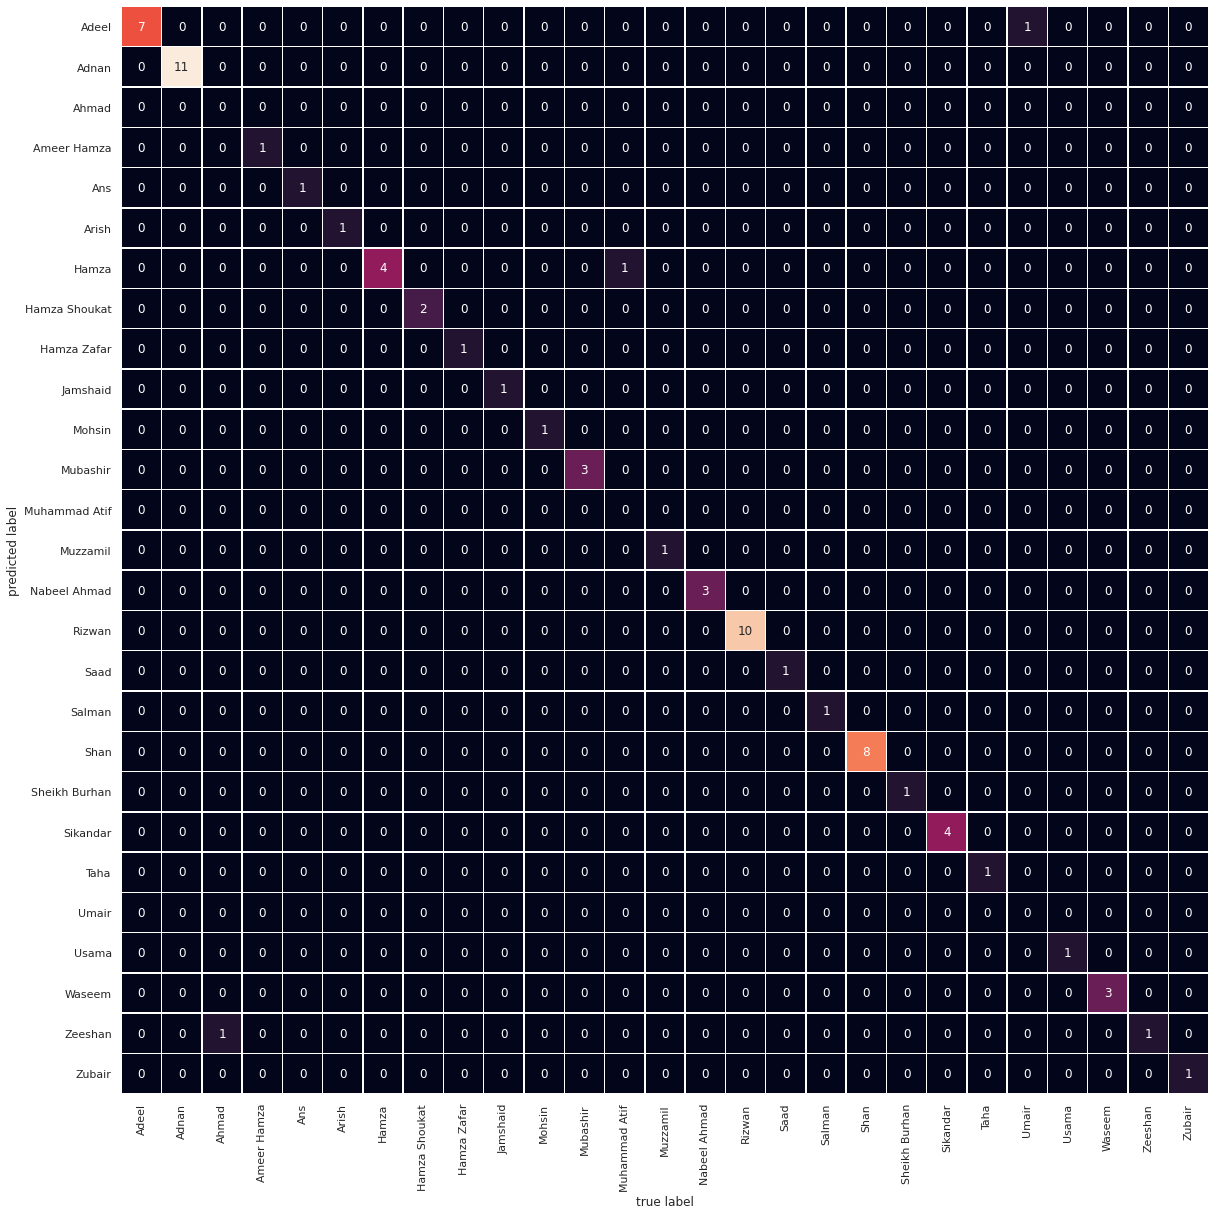

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

mat = confusion_matrix(lab, model_predictions)
sns.heatmap(mat.T, square=True, annot=True, linewidths=.5, ax=ax, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [15]:
#finding accuracy from the confusion matrix.
a = mat.shape
corrPred = 0
falsePred = 0

for row in range(a[0]):
    for c in range(a[1]):
        if row == c:
            corrPred +=mat[row,c]
        else:
            falsePred += mat[row,c]
print('Correct predictions: ', corrPred)
print('False predictions', falsePred)
print ('\n\nAccuracy of the Naive Bayes Clasification is: ', (corrPred/(mat.sum()) * 100))

Correct predictions:  69
False predictions 3


Accuracy of the Naive Bayes Clasification is:  95.83333333333334


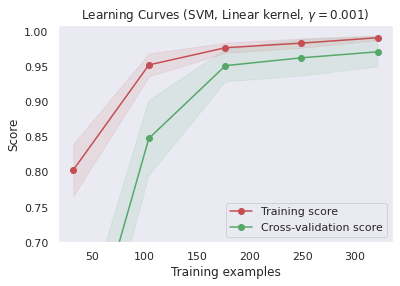

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC


def plot_learning_curve(estimator, title, x1, y1, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x1, y1, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (SVM, Linear kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel="linear",gamma=0.001)
plot_learning_curve(estimator, title, emb_array, labels, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()